# CC  Project
Giulio Umbrella
2021132

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import confusion_matrix
from scipy import cluster

torch.manual_seed(42)

## 1 Convolutional autoencoder

In [2]:
# Data import

# Transformation
transform = transforms.Compose(
    [transforms.ToTensor()])

data_dir = './DataMINST'
# Training set
training_set = torchvision.datasets.MNIST(data_dir, train=True, download=True,
                                          transform = transform)
# Test set
test_set = torchvision.datasets.MNIST(data_dir, train=False, download=True,
                                         transform = transform)


In [3]:
# Normalization
training_set.data = (training_set.data.type(torch.FloatTensor)/255)
test_set.data = (test_set.data.type(torch.FloatTensor)/255)

In [4]:
# Define model

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2,return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        # Encoder
        self.enc1 = nn.Conv2d(1, 32, kernel_size = 3, padding =1)
        self.enc2 = nn.Conv2d(32, 16, kernel_size = 3, padding =1)
        self.fc1 = nn.Linear(7*7*16,80)
        self.fc2 = nn.Linear(80,49)
        
        # Decoder
        self.fc3 = nn.Linear(49,80)
        self.fc4 = nn.Linear(80, 7*7*16)
        self.dec2 = nn.ConvTranspose2d(16, 32 ,kernel_size = 3, padding =1)
        self.dec1 = nn.ConvTranspose2d(32,1 ,kernel_size = 3, padding =1)
        
    def encoder(self, x, rtn_pooling_index = True):
        
        # Conv
        out, con_idx1 = self.pool(torch.tanh(self.enc1(x)))
        out, con_idx2 = self.pool(torch.tanh(self.enc2(out)))
        # Flattening
        out = out.view(-1, 7*7*16 )
        # Linear
        out = self.fc2(torch.tanh(self.fc1(out)))
        if rtn_pooling_index:
            return out, con_idx1, con_idx2
        else:
            return out
        
    def decoder(self, x,con_idx1, con_idx2):
        # Linear
        out = self.fc4(torch.tanh(self.fc3(x)))
        # Unflattening
        out = out.view(-1, 16,7,7)
        
        # Conv
        out = self.dec2(torch.tanh(self.unpool(out,con_idx2)))
        out = self.dec1(torch.tanh(self.unpool(out,con_idx1)))
        out = F.relu(out)
        return out
              
    def forward(self,x):
        out, con_idx1, con_idx2 = self.encoder(x)
        out = self.decoder(out,con_idx1, con_idx2)
        return out

In [5]:
# Training loop function
def training_loop(n_epochs, optimizer, model, loss_fn ,data):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs in data:
                        
            # decoder representations
            decoded_data = model(imgs)
            
            # no need for labels - unsupervised learning
            loss = loss_fn(decoded_data, imgs)
            
            # update the parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        # function for print values
        print('Epoch {}, Training loss {}'.format( epoch, loss_train / len(data)))
            

In [6]:
# Parameters
# con_autoenc = Net().to(device = device)
con_autoenc = ConvAutoencoder()
loss_fn_con_autoenc = nn.MSELoss()
optimizer_con_autoenc = torch.optim.Adam(con_autoenc.parameters(), lr=0.0001)
n_epochs_con_autoenc = 5
batch_size = 100 

In [7]:
ts_split = torch.split(training_set.data, 100)
for i in ts_split:
    i.unsqueeze_(1)

# input image size 1,28,28    
    
# Train the model
training_loop(
            n_epochs = n_epochs_con_autoenc,
            optimizer = optimizer_con_autoenc,
            model = con_autoenc,
            loss_fn = loss_fn_con_autoenc,
            data = ts_split)

Epoch 0, Training loss 0.04638121568908294
Epoch 1, Training loss 0.012160601750171434
Epoch 2, Training loss 0.008056282233446836
Epoch 3, Training loss 0.005989626639833053
Epoch 4, Training loss 0.004738199969287962


In [8]:
# Save autoencoder
# torch.save(con_autoenc.state_dict(), 'SavedModels/' + 'autoencoder.pt')

In [ ]:
# Load autoencoder
con_autoenc = ConvAutoencoder()
con_autoenc.load_state_dict(torch.load('SavedModels/' + 'autoencoder.pt'))

Text(0.5, 1.0, 'Reconstructed 0')

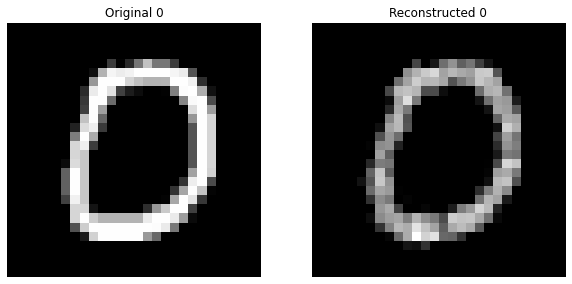

In [9]:
idx = 10

img_original = test_set.data[idx]
img_reconstructed= con_autoenc(test_set.data[idx].view(1,1,28,28)).squeeze(0).squeeze(0).detach().numpy()


fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img_original, cmap = 'gray')
plt.axis('off')
plt.title("Original " + format(test_set.targets[idx]) )
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img_reconstructed, cmap = 'gray')
plt.axis('off')
plt.title("Reconstructed " + format(test_set.targets[idx]) )

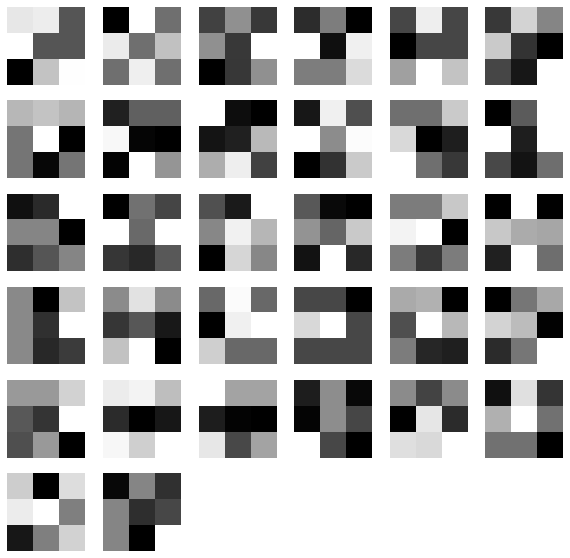

In [10]:
# PRINT WEIGHTS FIRST LAYER
# apply a threshold on the values
fig = plt.figure(figsize=(10, 10))
rows = 6
columns = 6
threshold = 0.1

for i in range(32):
    fig.add_subplot(rows, columns, i+1)
    x = con_autoenc.enc1.weight[i].squeeze(0)
    x = x*(abs(x) > threshold)
    x = x.detach().numpy()
    plt.imshow(x, cmap = 'gray')
    plt.axis('off')


In [ ]:
# WIP PRINT WEIGHT SECOND LAYER
# Attenzioe, qui abbiamo molti piu' layers
con_autoenc.enc2.weight.shape

## 2 Linear read-out

In [11]:
# define linear model

class Perceptron(torch.nn.Module):
    def __init__(self,encoded_layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(encoded_layer_size, 10)

    def forward(self, x):
        output = self.linear(x)
        if output.shape == torch.Size([10]):
            output.unsqueeze_(0)
        
        return output

In [12]:
# Freeze all the parameters in the convolutional autoencoder
for param in con_autoenc.parameters():
    param.requires_grad = False

In [13]:
# Encoded representation of data
encoded_training_set  = con_autoenc.encoder(training_set.data.unsqueeze(1),False)


In [14]:
# Train linear model from the reconstruction
perceptron = Perceptron(49)
optimizer_perceptron = optim.Adam(perceptron.parameters(), lr=0.001)
loss_fn_perceptron = nn.CrossEntropyLoss()
epochs_perceptron = 1000

for epoch in range(1,epochs_perceptron+1): 

    perceptor_predictions = perceptron(encoded_training_set)
    loss_perceptron = loss_fn_perceptron(perceptor_predictions, training_set.targets)

    optimizer_perceptron.zero_grad()
    loss_perceptron.backward()
    optimizer_perceptron.step()

    if epoch % 100 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs_perceptron, loss_perceptron))

epoch : 100/1000, loss = 1.774677
epoch : 200/1000, loss = 1.446412
epoch : 300/1000, loss = 1.235622
epoch : 400/1000, loss = 1.092650
epoch : 500/1000, loss = 0.990198
epoch : 600/1000, loss = 0.913356
epoch : 700/1000, loss = 0.853577
epoch : 800/1000, loss = 0.805678
epoch : 900/1000, loss = 0.766391
epoch : 1000/1000, loss = 0.733524


In [15]:
# Save perceptron
# torch.save(perceptron.state_dict(), 'SavedModels/' + 'perceptron.pt')

In [16]:
# Load autoencoder
perceptron = Perceptron(49)
perceptron.load_state_dict(torch.load('SavedModels/' + 'perceptron.pt'))


<All keys matched successfully>

In [17]:
def compute_accuracy(predictions, targets):
    predictions_indice = predictions.max(axis=1).indices
    accuracy = (predictions_indice == targets ).sum() / len(targets)
    return accuracy

In [18]:
# Encode validation set features
encoded_test_set = con_autoenc.encoder(test_set.data.unsqueeze(1),False)
prediction_test_set = perceptron(encoded_test_set)

test_set_accuracy = compute_accuracy(prediction_test_set, test_set.targets)
print("Test set accuracy: ", test_set_accuracy)

Test set accuracy:  tensor(0.8200)


In [19]:
# Confusion matrix
y_true = test_set.targets
y_pred = prediction_test_set.max(axis=1).indices.detach().numpy()

confusion_matrix(y_true, y_pred)

array([[ 900,    1,    3,   15,    1,    9,   15,    4,   30,    2],
       [   0, 1085,    7,    7,    0,    1,    4,    0,   31,    0],
       [  18,    7,  837,   32,   31,   19,   41,   16,   27,    4],
       [   5,   20,   59,  754,    1,   58,    6,   34,   57,   16],
       [   3,    5,    5,    0,  812,    2,   13,    6,   11,  125],
       [  14,   21,   29,  142,   28,  565,   15,   15,   48,   15],
       [   7,   21,   29,    1,   13,   17,  862,    0,    8,    0],
       [   3,   24,   12,    7,   15,    1,    0,  855,   21,   90],
       [  15,   37,    9,   63,   16,   55,   21,   29,  716,   13],
       [  11,   17,    5,   15,   63,    4,    0,   55,   25,  814]])

In [20]:
# Perform linkage clustering and computee the dendogram 
def plot_dendrogram(mean_repr_matrix, dist_measure, title=""):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method = dist_measure)  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title + " with " + dist_measure +' distance measure')

In [21]:
# Compute the 'average' encoded digit 
avg_encoded_list = []

for label in range(10):
    avg_encoded = encoded_training_set[ training_set.targets == label].mean(axis=0)
    avg_encoded = avg_encoded.detach().numpy()
    avg_encoded_list.append(avg_encoded)

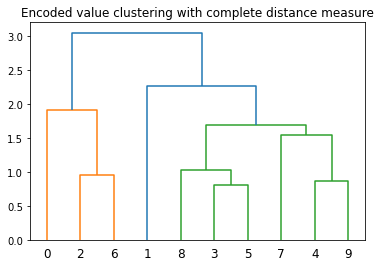

In [22]:
plot_dendrogram(avg_encoded_list, 'complete' ,"Encoded value clustering")

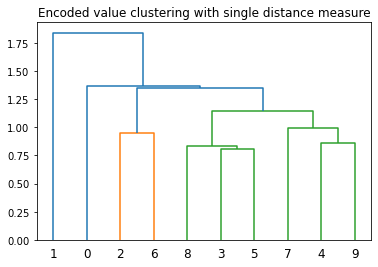

In [23]:
plot_dendrogram(avg_encoded_list, 'single' ,"Encoded value clustering")

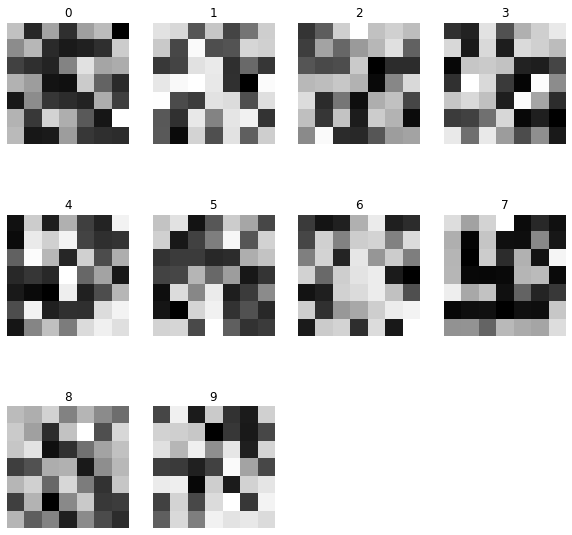

In [24]:
# Plot perceptron
for par in perceptron.parameters():
    x = par
    break

fig = plt.figure(figsize=(10, 10))
rows = 3
columns = 4

for i in range(10):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x[i].view(7,7).detach().numpy(), cmap = 'gray')
    plt.title(str(i))
    plt.axis('off')


## 3 Transfer learning Fashion MINST

In [58]:
# Load fashion MINST

# Transformation
transform = transforms.Compose(
    [transforms.ToTensor()])

data_dir = './DataFashionMNIST'
# Training set
training_set_FM = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True,
                                          transform = transform)
# Test set
test_set_FM = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True,
                                         transform = transform)


In [59]:
# Normalization
training_set_FM.data = (training_set_FM.data.type(torch.FloatTensor)/255)
test_set_FM.data = (test_set_FM.data.type(torch.FloatTensor)/255)

In [60]:
# Encode fashion MINST 
encoded_training_set_FM= con_autoenc.encoder(training_set_FM.data.unsqueeze(1),False)

In [64]:
# Train linear model for fashion MINST 

perceptron_FM = Perceptron(49)
optimizer_perceptron_FM = optim.Adam(perceptron_FM.parameters(), lr=0.001)
loss_fn_perceptron_FM = nn.CrossEntropyLoss()
epochs_perceptron_FM = 1000

for epoch in range(1,epochs_perceptron_FM+1): 

    perceptor_predictions_FM = perceptron_FM(encoded_training_set_FM).squeeze()
    loss_perceptron_FM = loss_fn_perceptron_FM(perceptor_predictions_FM, training_set_FM.targets)

    optimizer_perceptron_FM.zero_grad()
    loss_perceptron_FM.backward()
    optimizer_perceptron_FM.step()
    
    if epoch % 100 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs_perceptron_FM, loss_perceptron_FM))

epoch : 100/1000, loss = 1.729632
epoch : 200/1000, loss = 1.401522
epoch : 300/1000, loss = 1.219828
epoch : 400/1000, loss = 1.106994
epoch : 500/1000, loss = 1.031035
epoch : 600/1000, loss = 0.976623
epoch : 700/1000, loss = 0.935719
epoch : 800/1000, loss = 0.903752
epoch : 900/1000, loss = 0.877995
epoch : 1000/1000, loss = 0.856709


In [69]:
# Validation perceptron accuracy
encoded_test_set_FM  = con_autoenc.encoder(test_set_FM.data.unsqueeze(1),False)
prediction_test_set_FM = perceptron_FM(encoded_test_set_FM)

test_set_accuracy_FM = compute_accuracy(prediction_test_set_FM, test_set_FM.targets)
print("Validation set accuracy: ",test_set_accuracy_FM)

Validation set accuracy:  tensor(0.7053)


## 4 FFN Feed forward network

In [37]:
# Define a FFN for the MINST database
class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size):
        super().__init__()
        self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
        self.output = torch.nn.Linear(first_hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        first_hidden_repr = F.relu(self.first_hidden(x))
        output = self.output(first_hidden_repr)
        return output

**NB** Metto il valore a 288 perche' e' il numero di paremetri del primo layer del convolutional autoencoder

In [38]:
# Train the FFN
hidden_layer_size = 288
ffn = Feedforward(288)

optimizer_ffn = optim.SGD(ffn.parameters(), lr=0.05)
loss_fn_ffn = nn.CrossEntropyLoss()
epochs_fnn = 100

for epoch in range(1, epochs_fnn+1):
    
    predictions_ffn = ffn(training_set.data)
    loss_ffn = loss_fn_ffn(predictions_ffn, training_set.targets)
    
    optimizer_ffn.zero_grad()
    loss_ffn.backward()
    optimizer_ffn.step()
    if epoch % 10 == 0:
        print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs_fnn, loss_ffn))


epoch 10/100, loss = 2.206591
epoch 20/100, loss = 2.092563
epoch 30/100, loss = 1.956394
epoch 40/100, loss = 1.798898
epoch 50/100, loss = 1.629446
epoch 60/100, loss = 1.461572
epoch 70/100, loss = 1.307171
epoch 80/100, loss = 1.173002
epoch 90/100, loss = 1.060429
epoch 100/100, loss = 0.967586


In [40]:
# Save FFN
# torch.save(ffn.state_dict(), 'SavedModels/' + 'FFN.pt')

In [32]:
# Load FFN
ffn = Feedforward(288)
ffn.load_state_dict(torch.load('SavedModels/' + 'FFN.pt'))

<All keys matched successfully>

In [39]:
# Accuracy on validation set 
prediction_test_ffn = ffn(test_set.data)
test_set_accuracy_ffn = compute_accuracy(prediction_test_ffn, test_set.targets)
print("Validation set accuracy feed forward network: ", test_set_accuracy_ffn)

Validation set accuracy feed forward network:  tensor(0.8308)


In [41]:
# Confusion matrix
y_true = test_set.targets
y_pred = prediction_test_ffn.max(axis=1).indices.detach().numpy()

confusion_matrix(y_true, y_pred)

array([[ 934,    0,    4,    3,    1,    5,   24,    1,    8,    0],
       [   0, 1105,    8,    4,    0,    0,    3,    0,   14,    1],
       [  23,   40,  826,   30,   22,    0,   31,   21,   38,    1],
       [   5,    9,   27,  887,    1,   11,    7,   25,   32,    6],
       [   3,   15,    6,    1,  839,    0,   22,    3,   14,   79],
       [  40,   35,   18,  179,   24,  470,   40,   15,   44,   27],
       [  26,   15,   22,    1,    7,   14,  866,    0,    7,    0],
       [   7,   54,   24,    0,   10,    0,    1,  893,    7,   32],
       [  21,   35,   14,   82,   11,    9,   29,   18,  724,   31],
       [  17,   17,    6,   13,  109,    3,    3,   63,   14,  764]])

## 5 Robustness to noise

In [42]:
# Function to insert noise
def inject_noise(mnist_data, noise_level):
    random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6  
    probability_tensor = torch.ones(mnist_data.shape)*noise_level
    mask_tensor = torch.bernoulli(probability_tensor)
    return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor


In [46]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

perceptron_accuracies = []
ffn_accuracies = []

for noise_level in noise_levels:
    # get noisy dataset
    mnist_test_with_noise = inject_noise(test_set.data, noise_level)
    
    # compute perceptron predictions
    encoded_test_set_noisy, _, _  = con_autoenc.encoder(mnist_test_with_noise.unsqueeze(1))
    predictions_perceptron_noisy = perceptron(encoded_test_set_noisy)
    perceptron_accuracies.append(compute_accuracy(predictions_perceptron_noisy, test_set.targets))
    
    # compute ffn predictions
    predictions_ffn_noisy = ffn(mnist_test_with_noise.view(-1,28*28))
    ffn_accuracies.append(compute_accuracy(predictions_ffn_noisy, test_set.targets))
    

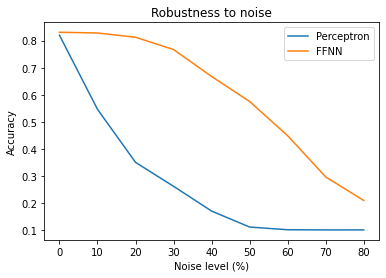

In [47]:
# Plot
fig, ax = plt.subplots()
ax.plot(range(len(noise_levels)), perceptron_accuracies)
ax.plot(range(len(noise_levels)), ffn_accuracies)

ax.set_title("Robustness to noise")
ax.set_xlabel("Noise level (%)")
ax.set_ylabel("Accuracy")
plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
plt.legend(["Perceptron", "FFNN"])

## 6 Adversarial Learning

In [48]:
# Freeze all the parameters in the convolutional autoencoder
for param in perceptron.parameters():
    param.requires_grad = False

In [49]:
def fgsm_attack(image, epsilon, data_grad, clamping):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon* sign_data_grad

    # Adding clipping to maintain [0,1] range
    if clamping == True:
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [50]:
def test_robustness_to_attack(model, loss_fn, images, labels, epsilon, clamping):
    
    num_correct = 0
    num_test = 0
    
    for image, label in zip(images, labels):
        
        image.requires_grad = True  
        
        output = model(image)
        
        init_pred = torch.argmax(output)
        
        if init_pred.item() != label.item():
            continue
                
        loss = F.nll_loss(output, label)
        
        model.zero_grad()
        loss.backward()
        data_grad = image.grad.data  # collect the gradient of the input data
        
        perturbed_image = fgsm_attack(image, epsilon, data_grad,clamping)

        # Re-classify the perturbed image
        output = model(perturbed_image)
        
        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == label.item():
            num_correct += 1
            
        num_test += 1

    # Calculate final accuracy for this epsilon
    final_acc = num_correct/float(num_test)

    return final_acc

In [51]:
epsilon_values = [0, .05, .1, .15, .2, .25]

In [52]:
# Prepare the input for the robustness test
loss_ffn = nn.CrossEntropyLoss()
accuracies_ffnn = []

for epsilon in epsilon_values:
    accuracy = test_robustness_to_attack(ffn, loss_ffn, test_set.data.unsqueeze(1), 
                                         test_set.targets.unsqueeze(1),epsilon,True)
    accuracies_ffnn.append(accuracy)




In [53]:
# Encode the test set
encoded_test_set  = con_autoenc.encoder(test_set.data.unsqueeze(1),False)

In [54]:
loss_perceptron = nn.CrossEntropyLoss()
accuracies_perceptron = []

for epsilon in epsilon_values:
    accuracy= test_robustness_to_attack(perceptron, loss_perceptron, encoded_test_set,
                                        test_set.targets.unsqueeze(1), epsilon, False)
    accuracies_perceptron.append(accuracy)


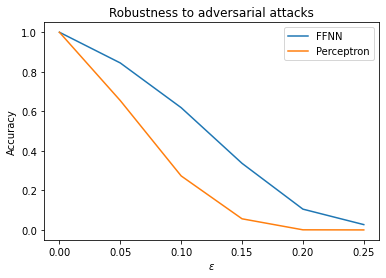

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_perceptron)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "Perceptron"])